In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta

In [3]:
faults = pd.read_csv('../data/J1939Faults.csv',low_memory=False)

In [4]:

columns_to_drop = ['ESS_Id', 
                   'actionDescription', 
                   'ecuSoftwareVersion', 
                   'ecuSerialNumber', 
                   'ecuModel', 
                   'ecuMake', 
                   'ecuSource', 
                   'faultValue', 
                   'MCTNumber']

In [5]:
faults_a = faults.drop(columns=columns_to_drop)


faults_a['EventTimeStamp'] = pd.to_datetime(faults_a['EventTimeStamp'])
faults_a['LocationTimeStamp'] = pd.to_datetime(faults_a['LocationTimeStamp'])


In [6]:
# Function to split time of day
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

# Apply the function to create a new column for time of day
faults_a['time_of_day'] = faults_a['EventTimeStamp'].dt.hour.apply(categorize_time_of_day)

faults_a['Month'] = faults_a['EventTimeStamp'].dt.month
faults_a['Year'] = faults_a['EventTimeStamp'].dt.year

In [7]:
diagnostics = pd.read_csv("../data/VehicleDiagnosticOnboardData.csv")


In [8]:
equipment_list = faults_a['EquipmentID'].unique().tolist()
# equipment_list = ['1439',
#  '1620',
#  '1365']

In [9]:
def nan_proportions(dataframe, key):
    nan_counts = dataframe.isnull().sum()
    total_rows = len(dataframe)
    nan_proportions = {}
    
    for column, nan_count in nan_counts.items():
        nan_proportion = nan_count / total_rows
        nan_proportions[(key, column)] = nan_proportion
    
    return nan_proportions

SPN 5246 is the full derate:

In [10]:
faults_a[(faults_a.spn==5246)].head(2)

,RecordID,EventTimeStamp,eventDescription,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,time_of_day,Month,Year
45,46,2015-02-21 12:10:51,NaN,5246,0,True,1,1395,36.065972,-86.433425,2015-02-21 12:11:27,Afternoon,2,2015
1918,1919,2015-02-22 19:44:55,NaN,5246,0,True,1,1395,36.066203,-86.434814,2015-02-22 19:46:27,Evening,2,2015


In [11]:
#filter trucks that have 5246 codes...
faults_by_truck = faults_a.groupby('EquipmentID').filter(lambda x: (x['spn']==5246).any())

In [12]:
faults_by_truck.to_csv('../data/faults_by_truck.csv')

In [12]:
faults_by_truck.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394531 entries, 5 to 1187315
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   RecordID               394531 non-null  int64         
 1   EventTimeStamp         394531 non-null  datetime64[ns]
 2   eventDescription       377481 non-null  object        
 3   spn                    394531 non-null  int64         
 4   fmi                    394531 non-null  int64         
 5   active                 394531 non-null  bool          
 6   activeTransitionCount  394531 non-null  int64         
 7   EquipmentID            394531 non-null  object        
 8   Latitude               394531 non-null  float64       
 9   Longitude              394531 non-null  float64       
 10  LocationTimeStamp      394531 non-null  datetime64[ns]
 11  time_of_day            394531 non-null  object        
 12  Month                  394531 non-null  int

feature selection?


One target column


#### needs
list of emission control spns

Find faults, look backwards 5 days, what are the fault codes...building a profile.  Find the most often thrown codes and start there. Add diagnostic information.  

You also want to do it on the whole dataset.  This is important because you want to look at false positives.  

In [13]:
faults_by_truck['EventTimeStamp'] = pd.to_datetime(faults_by_truck['EventTimeStamp'])

# Check the DataFrame's structure
print(faults_by_truck.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 394531 entries, 5 to 1187315
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   RecordID               394531 non-null  int64         
 1   EventTimeStamp         394531 non-null  datetime64[ns]
 2   eventDescription       377481 non-null  object        
 3   spn                    394531 non-null  int64         
 4   fmi                    394531 non-null  int64         
 5   active                 394531 non-null  bool          
 6   activeTransitionCount  394531 non-null  int64         
 7   EquipmentID            394531 non-null  object        
 8   Latitude               394531 non-null  float64       
 9   Longitude              394531 non-null  float64       
 10  LocationTimeStamp      394531 non-null  datetime64[ns]
 11  time_of_day            394531 non-null  object        
 12  Month                  394531 non-null  int

In [14]:
spn_5246_df = faults_by_truck[faults_by_truck['spn'] == 5246]

# Need a holding tank
profile_results = pd.DataFrame()

# Iterate over the spn_5246_df, find the 5 days previous... 
for _, row in spn_5246_df.iterrows():
    start_date = row['EventTimeStamp'] - pd.Timedelta(days=5)
    end_date = row['EventTimeStamp']
    
    # Filter the original DataFrame for the date range and exclude the current spn=5246 rows
    temp_df = faults_by_truck[(faults_by_truck['EventTimeStamp'] >= start_date) & 
                              (faults_by_truck['EventTimeStamp'] < end_date)]
    
    # Append the temp df to the results df
    profile_results = pd.concat([profile_results, temp_df])

# Drop dups?
profile_results = profile_results.drop_duplicates()

print(profile_results)

         RecordID      EventTimeStamp  \
5               6 2015-02-21 11:40:22   
9              10 2015-02-21 11:41:55   
10             11 2015-02-21 11:42:19   
13             14 2015-02-21 11:43:40   
15             16 2015-02-21 11:45:06   
...           ...                 ...   
1185270   1246394 2020-02-27 12:07:55   
1185271   1246395 2020-02-27 12:08:48   
1185272   1246396 2020-02-27 12:08:48   
1185273   1246397 2020-02-27 12:10:05   
1185276   1246400 2020-02-27 12:10:53   

                                   eventDescription   spn  fmi  active  \
5           Low (Severity Low) Engine Coolant Level   111   17    True   
9           Low (Severity Low) Engine Coolant Level   111   17   False   
10          Low (Severity Low) Engine Coolant Level   111   17    True   
13          Low (Severity Low) Engine Coolant Level   111   17   False   
15          Low (Severity Low) Engine Coolant Level   111   17   False   
...                                             ...   ...  ... 

In [15]:
temp_df.shape

(302, 14)

In [16]:
spn_5246_df.shape

(1195, 14)

In [17]:
profile_results.shape

(288885, 14)

In [18]:
profile_results.head(2)

,RecordID,EventTimeStamp,eventDescription,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,time_of_day,Month,Year
5,6,2015-02-21 11:40:22,Low (Severity Low) Engine Coolant Level,111,17,True,1,1417,33.043564,-96.179722,2015-02-21 11:40:59,Morning,2,2015
9,10,2015-02-21 11:41:55,Low (Severity Low) Engine Coolant Level,111,17,False,1,1417,33.039953,-96.182592,2015-02-21 11:41:51,Morning,2,2015


### The next two columns were bug tracing

#### Look for the following:
<class 'pandas.core.series.Series'>, <class 'pandas.core.frame.DataFrame'>, or <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

##### Look for incorrect dt columns?

for col in profile_results.columns:
    print(f"Column: {col}")
    print(profile_results[col].apply(type).value_counts())
    print("\n")

In [19]:
##Since we grouped by truck and sorted by SPN 5246, Find the top spns per truck.

top_spn_counts = {}

for equipment_id, group_df in profile_results.groupby('EquipmentID'):
    spn_counts = group_df['spn'].value_counts().sort_values(ascending=False)
    top_spn_counts[equipment_id] = spn_counts.head(10)

# Print
for equipment_id, counts in top_spn_counts.items():
    print(f"Top 5 counts of spn values for equipmentID {equipment_id}:")
    print(counts)
    print()

Top 5 counts of spn values for equipmentID 105349576:
6802    30
3363    21
111     20
95      14
1569    12
1761    12
110      8
157      8
3031     6
3364     6
Name: spn, dtype: int64
Top 5 counts of spn values for equipmentID 105360462:
1569    1
3360    1
5246    1
Name: spn, dtype: int64
Top 5 counts of spn values for equipmentID 105411041:
5246    1
1569    1
3360    1
Name: spn, dtype: int64
Top 5 counts of spn values for equipmentID 105427203:
794     30
1761     4
563      2
789      2
790      2
4376     2
4334     2
3361     2
793      2
791      2
Name: spn, dtype: int64
Top 5 counts of spn values for equipmentID 1329:
111      28
50353    11
2863     10
4344      2
5246      2
1569      2
3031      2
3242      2
4096      2
1761      2
Name: spn, dtype: int64
Top 5 counts of spn values for equipmentID 1339:
50353    30
596      14
4364      5
3362      4
1569      4
111       2
51923     2
723       2
5394      2
4363      2
Name: spn, dtype: int64
Top 5 counts of spn va

In [20]:
faults_by_truck[(faults_by_truck.EquipmentID=='1595')]

,RecordID,EventTimeStamp,eventDescription,spn,fmi,active,activeTransitionCount,EquipmentID,Latitude,Longitude,LocationTimeStamp,time_of_day,Month,Year
101,102,2015-02-21 12:52:35,Low (Severity Low) Engine Coolant Level,111,17,True,1,1595,36.101712,-85.237685,2015-02-21 12:53:11,Afternoon,2,2015
104,105,2015-02-21 12:58:22,Low (Severity Low) Engine Coolant Level,111,17,False,1,1595,36.065277,-85.187500,2015-02-21 12:58:17,Afternoon,2,2015
179,180,2015-02-21 13:57:13,Low (Severity Low) Engine Coolant Level,111,17,True,1,1595,35.887083,-84.830740,2015-02-21 13:57:49,Afternoon,2,2015
180,181,2015-02-21 13:58:34,Low (Severity Low) Engine Coolant Level,111,17,False,1,1595,35.884629,-84.822175,2015-02-21 13:58:29,Afternoon,2,2015
316,317,2015-02-21 16:00:18,Low (Severity Low) Engine Coolant Level,111,17,True,1,1595,36.134120,-83.293657,2015-02-21 16:00:54,Afternoon,2,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
870047,894112,2017-10-18 12:15:50,Low (Severity Medium) Engine Cooling System Mo...,3060,18,False,1,1595,35.740416,-84.044074,2017-10-18 12:15:46,Afternoon,10,2017
884748,908813,2017-11-10 02:58:11,Low (Severity Medium) Engine Coolant Level,111,18,True,1,1595,33.732731,-80.933101,2017-11-10 02:58:48,Evening,11,2017
884749,908814,2017-11-10 03:00:00,Low (Severity Medium) Engine Coolant Level,111,18,False,1,1595,33.748518,-80.942546,2017-11-10 02:59:56,Evening,11,2017
885945,910010,2017-11-11 23:47:56,Low (Severity Medium) Engine Coolant Level,111,18,True,1,1595,35.138333,-82.103611,2017-11-11 23:48:32,Evening,11,2017


Find a list of sensor codes that are important for us.
Make dummy columns, onehotencoded
Go back 5 days from spn 5246
Find all true values.

What will we populate the column with?

What if we just add them together.  

Be sure to think about interaction terms. 

Prahlad tries:
    start with a truck
    Once it breaks, start over
    


In [21]:
#Take out a few rows
faults_by_truck = faults_by_truck.drop(['EquipmentID',
                                       'eventDescription',
                                       'EventTimeStamp', 
                                       'LocationTimeStamp'
                                       ], axis=1)

In [22]:
#One hot 5246
faults_by_truck['onehotcolumn'] = (faults_by_truck.spn=='5246').astype(int)

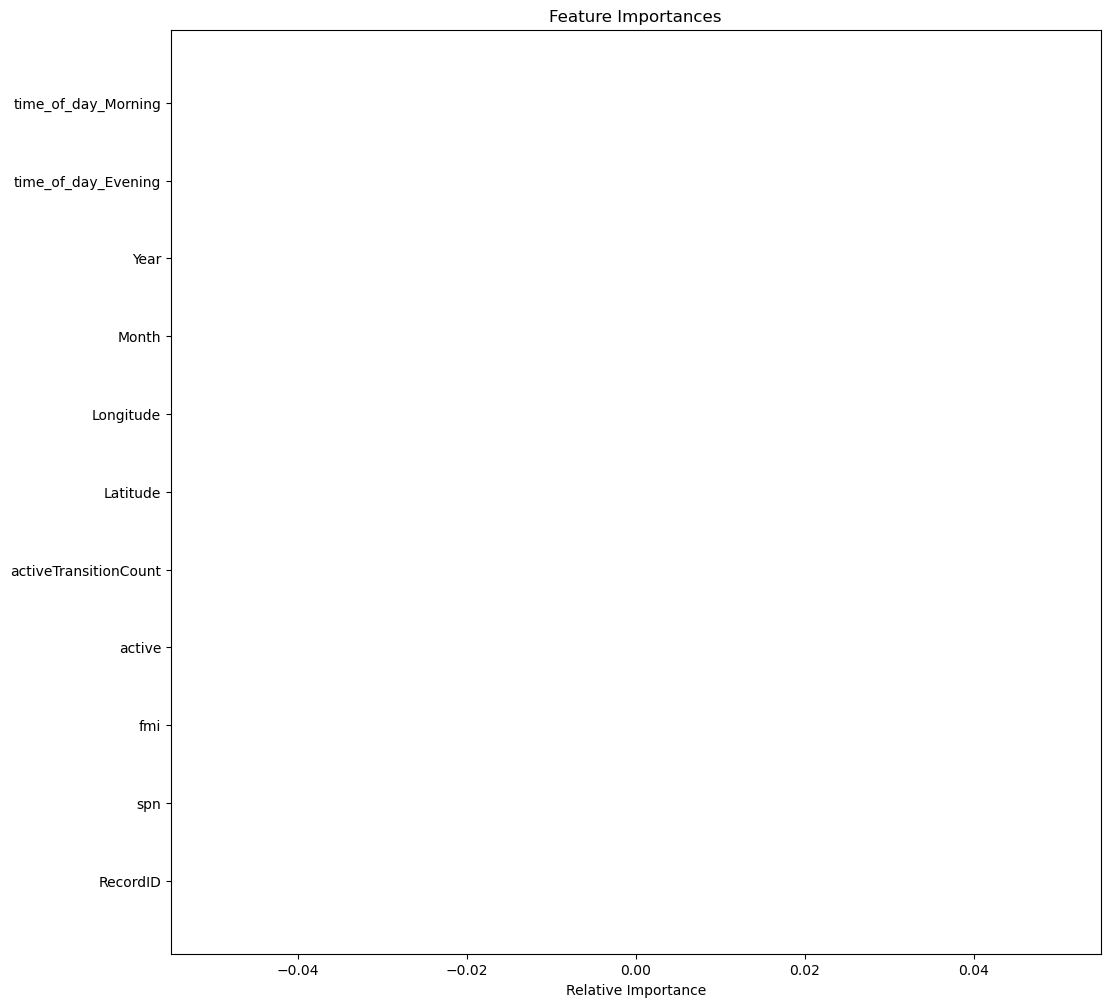

In [23]:
#First working pass w/ feature selection:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt

# First, encode the target variable using LabelEncoder
le = LabelEncoder()
y = le.fit_transform(faults_by_truck['onehotcolumn'])

# Drop the target column from the dataset
X = faults_by_truck.drop(columns=['onehotcolumn'])

# Convert categorical columns to one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Standardize features by removing  mean and scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize and train the RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

# Collect and display feature importances
features = X.columns
importances = forest.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()